In [233]:
from scipy import sparse, stats
from math import exp
from sklearn import cluster, metrics
import matplotlib.pyplot as plt
import itertools

In [263]:
def generate_block(size, prob, symmetric=False):
    density = stats.binom.rvs(size[0] * size[1], prob, size=1) / (size[0] * size[1])
    m = sparse.random(size[0], size[1], density)
    m.data[:] = 1
    
    if symmetric:
        if size[0] != size[1]:
            raise RuntimeError("symmetric matrix must be square")
        m = sparse.triu(m, k=1) + sparse.triu(m, k=1).transpose()
        # also doesn't include diagonal
    
    return m

def visualize(m):
    plt.spy(m, markersize=1)

def generate_sbm(block_sizes, block_probs):
    k = len(block_sizes)
    blocks = [[None for i in range(k)] for j in range(k)]
    
    for i in range(k):
        for j in range(i, k):
            blocks[i][j] = generate_block(
                (block_sizes[i], block_sizes[j]),
                block_probs[i][j],
                symmetric=(i == j)
            )
            if i < j:
                blocks[j][i] = blocks[i][j].transpose()
    
    return sparse.bmat(blocks)
    
def perturb_prob(eps):
    return 1 / (exp(eps) + 1)

def perturb_symmetric(m, eps):
    p = perturb_prob(eps)
    error = generate_block(m.get_shape(), p, symmetric = True)
    return abs(m - error)

def recover_labels(A, k):
    eigs = sparse.linalg.eigsh(A, k)[1]
    kmeans = cluster.KMeans(n_clusters=k)
    return kmeans.fit(A).labels_

def label_accuracy(labels, lengths):
    k = len(lengths)
    accuracy = 0
    
    # This is not optimal, but we're using small k, so it's no biggie.
    for p in itertools.permutations(range(k)):
        truth = []
        for i in range(k):
            truth.extend([p[i]] * lengths[i])
        accuracy = max(accuracy, metrics.accuracy_score(labels, truth))
    
    return accuracy

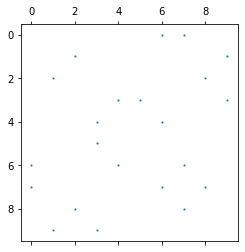

In [264]:
visualize(generate_block((10, 10), 0.3, symmetric=True))

In [278]:
lengths = [400, 400, 400]
probs = [
    [.1, .01, .01],
    [.01, .1, .01],
    [.01, .01, .1]
]

A = generate_sbm(lengths, probs)
B = perturb_symmetric(A, 2)

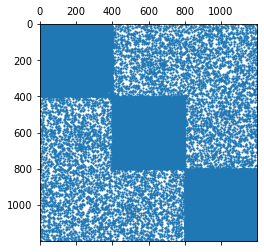

In [279]:
visualize(A)

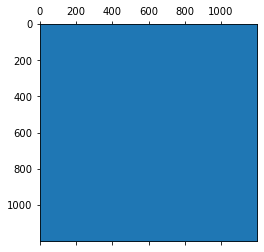

In [280]:
visualize(B)

In [281]:
labels = recover_labels(A, 3)
label_accuracy(labels, lengths)

1.0

In [282]:
labels_priv = recover_labels(B, 3)
label_accuracy(labels_priv, lengths)

0.9775